<a href="https://colab.research.google.com/github/lucasfldmn/twrds_unbiased_anns/blob/main/Towards_Unbiased_ANNs_from_Biased_Training_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook accompanies the thesis "Towards Unbiased ANNs from Biased Training Data". We provide a fully functional implementation of the most important findings in order to replicate them within this notebook in the spirit of open science. 

As the structure of this notebook mirrors that of the thesis we encourage the reader to jump back-and-forth for a more detailed or a moore implementation-focussed perspective.

Note that this notebook is **not** a complete TL;DR of the thesis as we will skip the theoretical background and disregard bias in classification settings completely. We will also not provide references within this notebook as you can find them in the related chapter in the thesis.

Now, let's start by framing the problem: Artifical intelligence (AI) and machine learning (ML) are taking the world by storm and they are increasingly employed in high-stakes tasks such as disease detection or credit scoring. 

In recent years, many machine learning applications have shown discrimination against subgroups of the population with minorities being affected more frequently. Examples of such "machine bias" span from large tech companies to small groups of researchers with severe consequences. For example, a black man was wronfully accused of a crime based on erroneous but confident security video footage analysis using machine learning.

A lot of research on preventing machine bias focuses on measuring and removing bias from popular training data sets. This is not enough for a practical setting where training data is often proprietary and no system of checks and balances is in place to measure let alone prevent discrimination.

We aim to create a minimal working example of a convolutional neural network that is robust against bias in the training data. To enable this, we create a framework using artificial training images that allows us to investigate more closely how features of biased training data affect learning of discrimination.

# Preparations

While you ponder the wide-reaching implications that machine bias can have on modern society, let us set up the colab environment by importing all necessary packages as well as additional functions.

## Imports

In [19]:
# Data handling
import pandas as pd
import numpy as np

# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Input, Layer, Conv2D, MaxPool2D, Flatten, Dense
from keras.utils.vis_utils import plot_model

# Plotting
import matplotlib.pyplot as plt

# Statistics
from scipy.stats import norm

## GitHub Integration

We need to clone our git repository in order to access functions for training data generation and model evaluation.

In [8]:
!rm -rf twrds_unbiased_anns
!git clone https://github.com/lucasfldmn/twrds_unbiased_anns/ -q

## Functions

Now we can import all the functions we need.

In [9]:
# Sample creation
from twrds_unbiased_anns.src.data.samples import create_sample_array, get_sample_data, get_sample_params, convert_sample_to_np_array, gen_from_sample, dataset_from_gen
# Evaluation
from twrds_unbiased_anns.src.data.eval import load_eval_samples, evaluate_performance, evaluate_model, store_results

# Experimental Setup

## Training Data

In this section we will explore the training data used for our tasks.

First, we will have a look at the sample array and the resulting sample images that we will use to train our model. Our sample contains multiple noisy images of two different types of shapes (square and circle) in two different colors (white and red). We can see color as a proxy for ethnicity and the shape type as a proxy for sex or gender.

The shape size varies per image and corresponds to the target variable that we aim to predict in our model. The exemplary shapes have a size of 150 (left) and 20 (right).

![White Square](https://github.com/lucasfldmn/twrds_unbiased_anns/raw/main/figures/shapes/white_square_150_noisy.png) | ![Red Circle](https://github.com/lucasfldmn/twrds_unbiased_anns/raw/main/figures/shapes/red_circle_20_noisy.png)

For each combination of the two shape attributes, we set its share, mean $\mu$, and standard deviation $\sigma$ in the training data. In this step we can introduce bias by varying the parameters across different attributes. 

For example, the configuration below is biased against red shapes because their average size is half of the size of white shapes. Additionally, the size of red shapes exhibits less variance than the white shapes. The sample contains 25% each of white squares, white circles, red squares, and red circles.

In [10]:
white_square = [25, 100, 20] # share, mean, stddev
white_circle = [25, 100, 20]
colorful_square = [25, 50, 3]
colorful_circle = [25, 50, 3]

We now generate a sample array that contains the shape attributes and the target variable sampled from a distribution based on the matching parameters. 
The first column encodes the shape color (1 = white), the second column denotes the shape type (1 = square), and the third column contains the shape size.

This leightweight format allows us to construct the training images and targets but requires much less disk space when saving samples for later use.

In [34]:
# Set size of training data
dataset_size = 400

# Prepare sample
train_sample = create_sample_array(dataset_size, white_square, white_circle, colorful_square, colorful_circle)
train_df = pd.DataFrame(train_sample)
train_df.columns = ["iswhite", "issquare", "size"]
train_df

,iswhite,issquare,size
0,0.0,1.0,52.0
1,0.0,0.0,57.0
2,1.0,1.0,99.0
3,0.0,1.0,50.0
4,1.0,0.0,80.0
...,...,...,...
395,1.0,1.0,143.0
396,1.0,1.0,110.0
397,0.0,1.0,50.0
398,0.0,0.0,56.0


Let's also plot the distribution of red vs. white shapes to see the impact of our parameter choice.

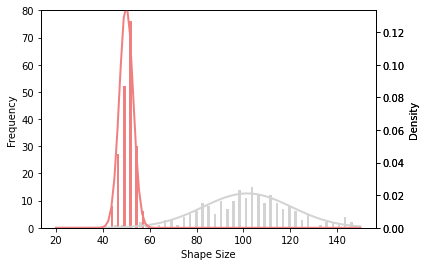

In [46]:
def plot_training_sample(df):
  # Plot parameters
  bins = 40
  color_white = "lightgrey"
  color_colorful = "lightcoral"
  colors = [color_white, color_colorful]

  fig = plt.plot(figsize=(20,10))
  ax = plt.gca()
  actual_white = df[df['iswhite'] == 1.0]["size"]
  actual_color = df[df['iswhite'] == 0.0]["size"]
  data = [actual_white, actual_color]
  ax.hist(data, color = colors, bins = bins, label = ["White Shapes", "Colorful Shapes"])
  ax.set_ylim(0,80)
  ax.set_ylabel('Frequency')
  ax.set_xlabel('Shape Size')
  for cat_data, color in zip(data, colors):
    # Fit a normal distribution to the data
    mu, std = norm.fit(cat_data)
    # Calculate PDF
    xmin, xmax = 20, 150
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    # Plot PDF
    ax2 = ax.twinx()
    ax2.plot(x, p, color = color, linewidth = 2)
    # Set limit of secondary axis based on frequency and total sample size 
    ax2.set_ylim([0, ax.get_ylim()[1] / (df.size/2)])
    ax2.set_ylabel('Density')

  # Show plot
  plt.show()

plot_training_sample(train_df)

As we can see, the distribution of shape size differs based on the shape color based on the parameters we chose.

## Evaluation Data

Similar to the training data, we also define an evaluation sample that does not contain any bias. We use the exact same values of shape size per attribute combination with a mean $\mu$ of 100 and a standard deviation $\sigma$ of 20. The evaluation sample contains 125 images for each of the four attribute combinations.

We save this evaluation sample and employ it for the evaluation of each model to see whether or not it has learned bias from the training data. If a model systematically favors one group over the other during the evaluation this indicates that it learned bias from its training data.

In [36]:
eval_sample_filename = "/content/twrds_unbiased_anns/data/eval/eval_500_mean_100_std_20.data"

eval_sample = load_eval_samples(eval_sample_filename)
df_eval_raw = pd.DataFrame(eval_sample)
df_eval = pd.DataFrame(df_eval_raw[0][0])
df_eval = df_eval.append(pd.DataFrame(df_eval_raw[0][1]))
df_eval = df_eval.append(pd.DataFrame(df_eval_raw[0][2]))
df_eval = df_eval.append(pd.DataFrame(df_eval_raw[0][3]))
df_eval.columns = ["is_white", "is_square", "shape_size"]
df_eval

,is_white,is_square,shape_size
0,1.0,1.0,115.0
1,1.0,1.0,127.0
2,1.0,1.0,113.0
3,1.0,1.0,107.0
4,1.0,1.0,92.0
...,...,...,...
120,0.0,0.0,77.0
121,0.0,0.0,84.0
122,0.0,0.0,102.0
123,0.0,0.0,108.0


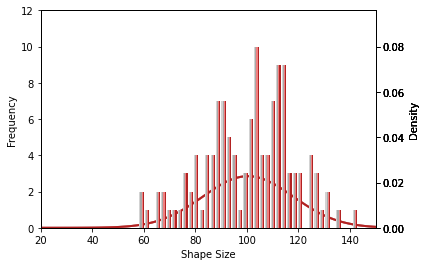

In [40]:
# Plot parameters
labels = ["White Shapes", "Red Shapes"]
bins = 40
color_white_square = "lightgrey"
color_white_circle = "darkgrey"
color_colorful_square = "lightcoral"
color_colorful_circle = "firebrick"
colors = [color_white_square, color_white_circle, color_colorful_square, color_colorful_circle]

# Plot results  
fig = plt.plot(figsize=(20,10))
ax = plt.gca()
w = df_eval[df_eval['is_white'] == 1.0]
r = df_eval[df_eval['is_white'] == 0.0]
actual_ws = w[w['is_square'] == 1.0].shape_size	
actual_wc = w[w['is_square'] == 0.0].shape_size
actual_rs = r[r['is_square'] == 1.0].shape_size	
actual_rc = r[r['is_square'] == 0.0].shape_size
data = [actual_ws, actual_wc, actual_rs, actual_rc]
ax.set_xlim(20,150)
ax.set_ylim(0,12)   
ax.hist(data, color = colors, bins = bins, label = labels)
ax.set_ylabel('Frequency')  
ax.set_xlabel('Shape Size')
for cat_data, color in zip(data, colors):
  # Fit a normal distribution to the data
  mu, std = norm.fit(cat_data)
  # Calculate PDF
  xmin, xmax = 20, 150
  x = np.linspace(xmin, xmax, 100)
  p = norm.pdf(x, mu, std)
  # Plot PDF
  ax2 = ax.twinx()
  ax2.plot(x, p, color = color, linewidth = 2)
  # Calcualte ylim of second axis based on first axis      
  ylim_max_1 = ax.get_ylim()[1]
  ylim_max_2 = ylim_max_1 / (df_eval.shape_size.size/4)
  ax2.set_ylim([0, ylim_max_2])
  ax2.set_ylabel('Density')
# Fix plot display order
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)
# Show plot
plt.show()  

We can see no difference between different colors or shape types in the evaluation sample. Differences in a model's prediction are purely based on learned bias from the training data.

## CNN Architecture

We use a simple convolutional neural network (CNN) to predict the shape size. Our CNN contains three convolutional layers with maximum pooling in between followed by three fully connected layers to funnel the flattened feature maps into a single value. 

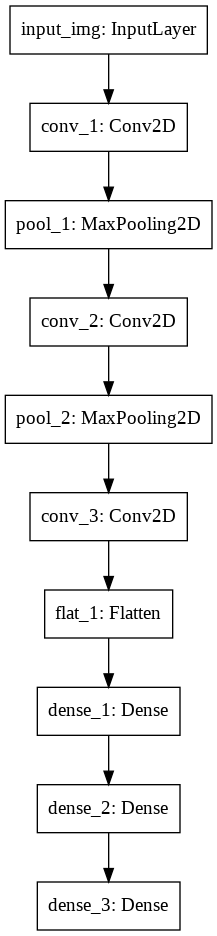

In [45]:
def make_cnn_model():
  model_input = Input(shape=(360, 360, 3), name="input_img")
  x = Conv2D(16, (3, 3), padding = "same", activation = "relu", name = "conv_1")(model_input)
  x = MaxPool2D(pool_size = (4, 4), name = "pool_1")(x)
  x = Conv2D(32, (3, 3), padding = "same", activation = "relu", name = "conv_2")(x)
  x = MaxPool2D(pool_size = (4, 4), name = "pool_2")(x)
  x = Conv2D(32, (3, 3), padding = "same", activation = "relu", name = "conv_3")(x)
  x = Flatten(name = "flat_1")(x)
  x = Dense(100, activation="relu", name = "dense_1")(x)
  x = Dense(20, activation="relu", name = "dense_2")(x)
  model_output = Dense(1, name = "dense_3")(x)
  return tf.keras.Model(model_input, model_output, name = "Base_CNN")

# Plot the model
plot_model(make_cnn_model())

# Discrimination in Regression Tasks

In this section we will evaluate how different features of the training data affect machine bias. For this, we will first take another look at the training data to develop hypotheses before putting them to a test experimentally.

## Hypotheses on Potential Sources

### Training Data Standard Deviation and Mean

TODO Text

Standard Deviation: 20, Mean: 100


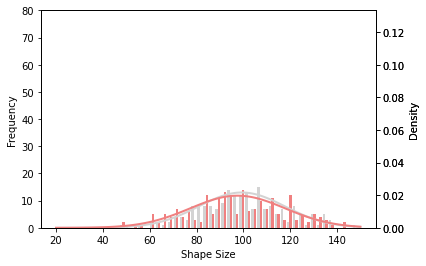

Standard Deviation: 20, Mean: 75


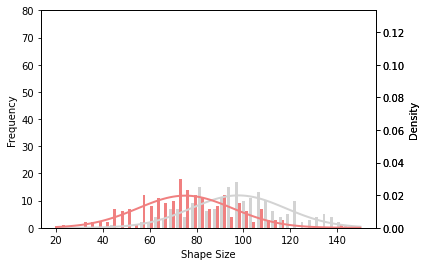

Standard Deviation: 20, Mean: 50


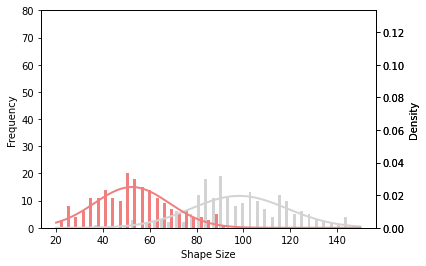

Standard Deviation: 3, Mean: 100


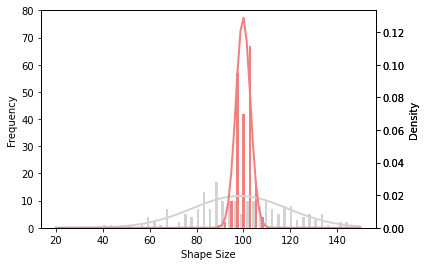

Standard Deviation: 3, Mean: 75


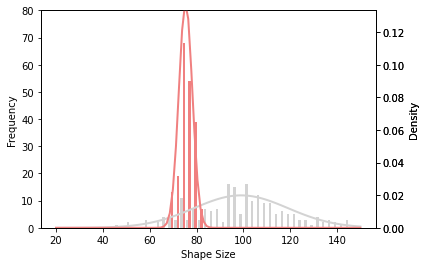

Standard Deviation: 3, Mean: 50


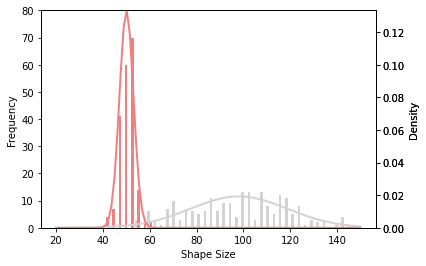

In [48]:
for stddev in [20, 3]:
  for mean in [100, 75, 50]:
    print("Standard Deviation: {}, Mean: {}".format(stddev, mean))
    # Generate training sample
    white_square = [25, 100, 20]
    white_circle = [25, 100, 20]
    colorful_square = [25, mean, stddev]
    colorful_circle = [25, mean, stddev]
    # Prepare sample
    train_sample = create_sample_array(dataset_size, white_square, white_circle, colorful_square, colorful_circle)
    train_df = pd.DataFrame(train_sample)
    train_df.columns = ["iswhite", "issquare", "size"]
    # Plot sample
    plot_training_sample(train_df)

### Training Data Share

### Distractor

The feature used to distinguish the groups in the training data might also impact the bias a model learns from it. Color can be learned more easily than the shape type as it only requires a single neuron to encode it. 

This could result in a stronger learned bias for groups split by color rather than shape type. However, the inverse is also possible: As learning the shape type requires the interaction of multiple neurons in our CNN, the difference in the shape size between the groups might be propagated more strongly throughout the network, causing a stronger discrimination between the groups. 

## Experiment: Training Data Distribution + Distractor

This experiment can be seen as a combination of the two experiments in the thesis. We test the effect of our three training data distribution parameters as well as the effect of our distractor.

In [ ]:
distractors = ["color", "shape"]
means = [100, 75, 50]
stddevs = [20, 3]
shares = [50, 5]

### Training Loop

In [ ]:
# Create empty list of all results
results = []

# Load evaluation sample
eval_samples = load_eval_samples(base_path + "twrds_unbiased_anns/data/eval/" + eval_sample_filename)

# Calculate number of steps per epoch
n_steps = int(dataset_size/batch_size)

# Store last m_diff
recent_m_diff = 0

# Iterate over all variable parameter combinations
for (modelname, lossname, category, m_diff, std, share) in itertools.product(models, loss_functions, categorical, mean_diffs, stddevs, minority_shares):
   
    # Get name of current iteration
    cur_name = name.format(modelname, lossname, category, m_diff, std, share)

    # Clear session once and then every time before a new model is trained
    tf.keras.backend.clear_session()

    # Get sample parameters
    white_square, white_circle, colorful_square, colorful_circle = get_sample_params(category, m_diff, std, share)

    # Prepare and save sample
    train_sample = create_sample_array(dataset_size, white_square, white_circle, colorful_square, colorful_circle)
    sample_filename = run_dir + "/" + "sample_{}_{}".format(cur_name, date_str)
    np.save(file = sample_filename, arr = train_sample)

    # Create dataset from training data sample
    data = dataset_from_gen(train_sample, n_epochs, batch_size, colors) 

    # Loop training for number of repeats
    for repeat in range(1, repeats_per_model + 1):   

        # Clear keras session
        tf.keras.backend.clear_session()

        # Create model and compile it
        model = get_model(modelname)
        model.compile(optimizer = get_optimizer(optimizer), loss = get_loss(lossname))  

        # Create logdir and callback
        logdir = log_base_dir + cur_name + "_" + str(repeat)
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

        # Do training
        model.fit(data, epochs = n_epochs, steps_per_epoch = n_steps, verbose = 0, callbacks=[tensorboard_callback])

        # Evaluate model
        # Create dictionary with model information
        row = {
            "run": run_name,
            "date": cur_date,
            "model": modelname,
            "loss": lossname,
            "category": category,
            "m_diff": m_diff,
            "stddev": std,
            "minority_share": share,
            "repeat": repeat
        } 
        # Run eval
        evaluate_model(model, eval_samples, row, results, colors) 

    # Save excel after each m_diff run    
    if m_diff != recent_m_diff:
        excel_name = "{}_{}_results.xlsx".format(run_name, date_str)
        filepath = results_path + excel_name
        store_results(results, filepath)

    # Store current m_diff
    recent_m_diff = m_diff
    
# Store again after everything has been run
excel_name = "{}_{}_results.xlsx".format(run_name, date_str)
filepath = results_path + excel_name
store_results(results, filepath)

### Results

# Robustness against Training Data Bias

## Gradient Reversal

In [3]:
# Gradient reversal operation
@tf.custom_gradient
def grad_reverse(x):
  y = tf.identity(x)
  def custom_grad(dy):
    return -dy
  return y, custom_grad

# Layer that reverses the gradient
class GradReverse(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()

  def call(self, x):
    return grad_reverse(x)

## GRAD Model

This piece of code generates and compiles a GRAD model with an arbitrary number of attributes defined by `n_attributes`, a custom weight for the target loss `target_loss_weight` and the $\lambda$ value `attr_loss_weight`.



In [5]:
# Model parameters
n_attributes = 2
target_loss_weight = 1.
attr_loss_weight = 1. 
    
# Input
model_input = Input(shape=(360, 360, 3), name="input_img")

# Feature extractor
x = Conv2D(32, (3, 3), padding = "same", activation = "relu", name = "conv_1")(model_input)
x = MaxPool2D(pool_size = (2, 2), name = "pool_1")(x)
x = Conv2D(64, (3, 3), padding = "same", activation = "relu", name = "conv_2")(x)
x = MaxPool2D(pool_size = (2, 2), name = "pool_2")(x)
x = Conv2D(64, (3, 3), padding = "same", activation = "relu", name = "conv_3")(x)
x = Flatten(name = "flat_1")(x)

# Target branch
x_target = Dense(100, activation="relu", name = "target_dense_1")(x)
x_target = Dense(20, activation="relu", name = "target_dense_2")(x_target)
target_output = Dense(1, name = "target_output")(x_target)
model_outputs = [target_output]   

# Create losses, weights and metrics
losses = {"target_output": tf.keras.losses.MeanSquaredError()}
target_metric = "mean_squared_error"
weights = {"target_output": target_loss_weight}
metrics = {"target_output": target_metric}    

# Split attribute loss across branches
attr_branch_weight = attr_loss_weight / n_attributes    

# Attribute branches
for i in range(n_attributes):
  # Gradient reversal layer
  x_attr = GradReverse()(x)
  # Funnel into sigmoid for binary classification of attributes
  x_attr = Dense(100, activation="relu", name = "attr_{}_dense_1".format(i))(x_attr)
  x_attr = Dense(20, activation="relu", name = "attr_{}_dense_2".format(i))(x_attr)
  output_name = "attr_{}_output".format(i)
  attr_output = Dense(1, activation = "sigmoid", name = output_name)(x_attr) 
  # Add to outputs
  model_outputs.append(attr_output)
  # Add to losses, weights and metrics
  losses[output_name] = tf.keras.losses.BinaryCrossentropy()
  weights[output_name] = attr_branch_weight
  metrics[output_name] = "accuracy"   
    
# Make model
grad_model = tf.keras.Model(inputs = model_input, outputs = model_outputs, name = "GRAD_CNN")

# Compile model
grad_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = losses, loss_weights = weights, metrics = metrics)

Let's visualize this model to see the attribute branches using our custom gradient reversal layer.

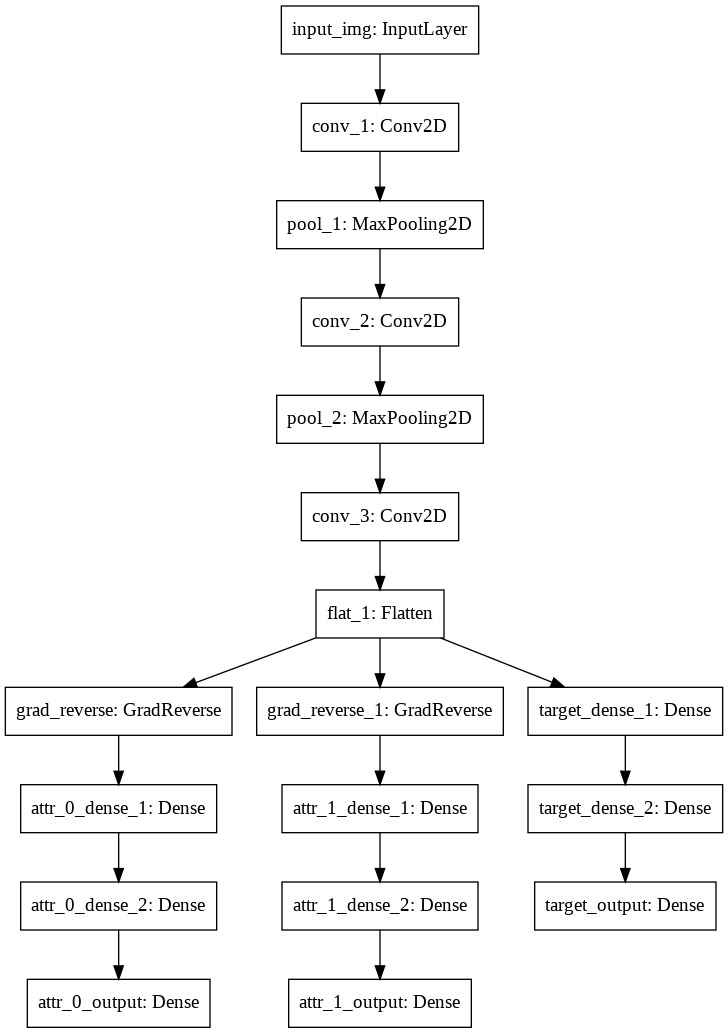

In [7]:
plot_model(grad_model)

## Model Selection

## Analysis